# StatML: Inference-Aware Optimisation
### Author: Dr Jonathon Langford
### Date: 24/1/2024
This tutorial demonstrates the "Inference-Aware optimisation" method discussed in my StatML lecture. In this tutorial you will:
* Train a simple binary classifier neural network (NN) to distinguish signal from background, using cross-entropy loss.
* Learn how to extract a "signal" yield in a toy particle physics problem.
* Construct a likelihood function which includes the effect of nuisance parameters
* Employ inference-aware techniques to maximize our sensitivity in the presence of nuisance parameters

[![Open in Colab]()](https://colab.research.google.com/github/jonathon-langford/statml/blob/main/inference_aware_optimisation)

## Part 0: loading of libraries

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib  
import matplotlib.pyplot as plt 
import seaborn

import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from scipy.interpolate import interp1d
from scipy.optimize import minimize

We will also define some useful functions to help later

In [2]:
def add_val_label(val):
    return "$%.2f^{+%.2f}_{-%.2f}$"%(val[0],abs(val[1]),abs(val[2]))

def find_crossings(graph, yval, spline_type="cubic", spline_points=1000, remin=True, return_all_intervals=False):

    # Build spline
    f = interp1d(graph[0],graph[1],kind=spline_type)
    x_spline = np.linspace(graph[0].min(),graph[0].max(),spline_points)
    y_spline = f(x_spline)
    spline = (x_spline,y_spline)

    # Remin
    if remin:
        x,y = graph[0],graph[1]
        if y_spline.min() <= 0:
            y = y-y_spline.min()
            y_spline -= y_spline.min()
            # Add new point to graph
            x = np.append(x, x_spline[np.argmin(y_spline)])
            y = np.append(y, 0.)
            # Re-sort
            i_sort = np.argsort(x)
            x = x[i_sort]
            y = y[i_sort]
            graph = (x,y)

    # Extract bestfit
    bestfit = graph[0][graph[1]==0]

    crossings, intervals = [], []
    current = None

    for i in range(len(graph[0])-1):
        if (graph[1][i]-yval)*(graph[1][i+1]-yval) < 0.:
            # Find crossing as inverse of spline between two x points
            mask = (spline[0]>graph[0][i])&(spline[0]<=graph[0][i+1])
            f_inv = interp1d(spline[1][mask],spline[0][mask])

            # Find crossing point for catch when yval is out of domain of spline points (unlikely)
            if yval > spline[1][mask].max(): cross = f_inv(spline[1][mask].max())
            elif yval <= spline[1][mask].min(): cross = f_inv(spline[1][mask].min())
            else: cross = f_inv(yval)

            # Add information for crossings
            if ((graph[1][i]-yval) > 0.)&( current is None ):
                current = {
                    'lo':cross,
                    'hi':graph[0][-1],
                    'valid_lo': True,
                    'valid_hi': False
                }
            if ((graph[1][i]-yval) < 0.)&( current is None ):
                current = {
                    'lo':graph[0][0],
                    'hi':cross,
                    'valid_lo': False,
                    'valid_hi': True
                }
            if ((graph[1][i]-yval) < 0.)&( current is not None ):
                current['hi'] = cross
                current['valid_hi'] = True
                intervals.append(current)
                current = None

            crossings.append(cross)

    if current is not None:
        intervals.append(current)

    if len(intervals) == 0:
        current = {
            'lo':graph[0][0],
            'hi':graph[0][-1],
            'valid_lo': False,
            'valid_hi': False
        }
        intervals.append(current)

    for interval in intervals:
        interval['contains_bf'] = False
        if (interval['lo']<=bestfit)&(interval['hi']>=bestfit): interval['contains_bf'] = True

    for interval in intervals:
        if interval['contains_bf']:
            val = (bestfit, interval['hi']-bestfit, interval['lo']-bestfit)

    if return_all_intervals:
        return val, intervals
    else:
        return val

## Neural network tools
def get_batches(arrays, batch_size=None, randomise=False, include_remainder=True):
    length = len(arrays[0])
    idx = np.arange(length)

    if randomise:
        np.random.shuffle(idx)

    n_full_batches = length // batch_size
    is_remainder = (length % batch_size > 0)

    if is_remainder and include_remainder:
        n_batches = n_full_batches + 1
    else:
        n_batches = n_full_batches

    for i_batch in range(n_batches):
        if i_batch < n_full_batches:
            batch_idx = idx[i_batch*batch_size:(i_batch+1)*batch_size]
        else:
            batch_idx = idx[i_batch*batch_size:]

        arrays_batch = [torch.Tensor(array[batch_idx]) for array in arrays]
        yield arrays_batch

def get_total_loss(model, loss, X, y, mean_over_batch=False):
    eval_batch_size = min(1024*2**8,len(X))
    losses = [] # contain loss from every batch

    with torch.no_grad():
        for X_tensor, y_tensor in get_batches([X, y], eval_batch_size):
            output = model(X_tensor)
            losses.append(loss(output, y_tensor).item()*len(output))

        if mean_over_batch:
            mean_loss = sum(losses) / len(losses)
        else:
            mean_loss = sum(losses) / len(X)

    return mean_loss

def get_network_output(df, features, model):
    with torch.no_grad():
        X = df[features].to_numpy() #Now check what corrections are for test_df

        eval_batch_size = min(1024*2**8,len(df))
        outputs = []

        for X_tensor, in get_batches([X], eval_batch_size):
              outputs.append(model(X_tensor).numpy())

        output = np.concatenate(outputs)

    return output

## Part 1: Setting up the problem
In particle physics analyses at the LHC, we deal with intractable likelihoods. Many latent variables are required to describe the trajectory from the parameters of interest (e.g. Higgs boson interaction strengths) to the observed data (e.g. electronic signals in the CMS detector). To integrate over all possible trajectories (latent features) we use sophisticated Monte-Carlo simulators. 

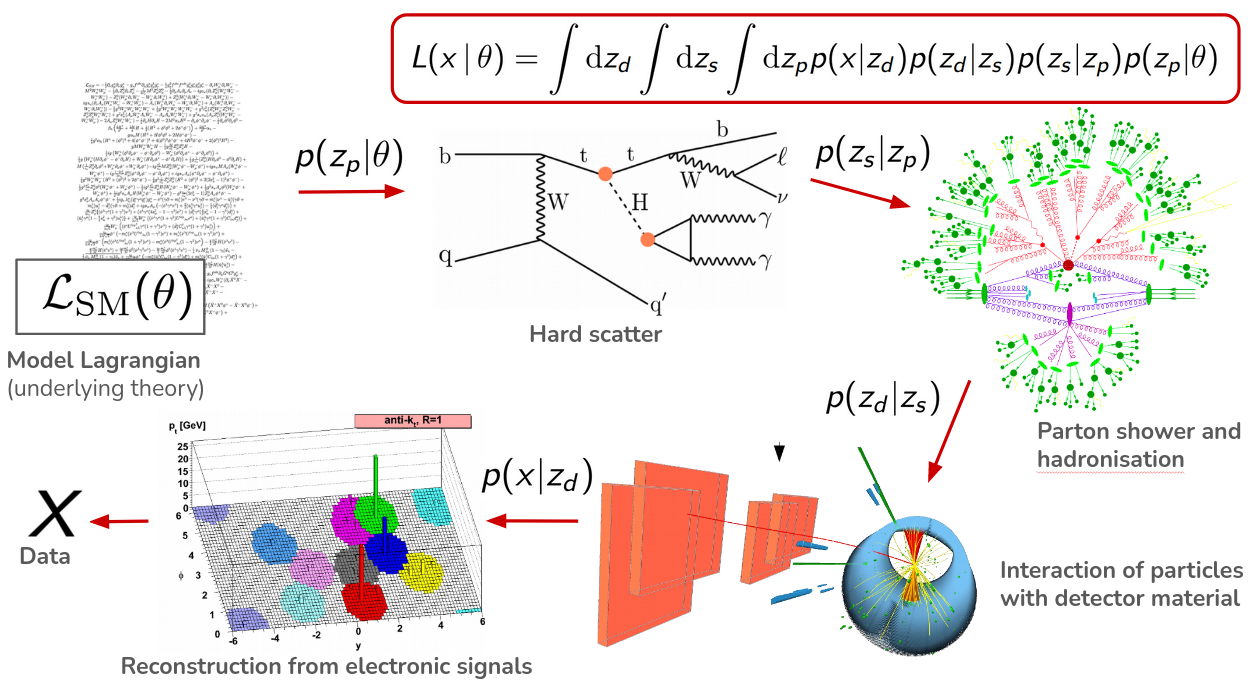

In this tutorial we will generate the simulated data from a known/tractable likelihood. This will help our understanding as we move through the tutorial, but please remember that this act of simply writing down the probability density functions for data points conditional on the underlying parameters is not possible.

Let's begin with a simple problem where we are only concerned with the rates of the signal and background processes i.e. no nuisance parameters.

Our data is defined by three variables, ($x_0,x_1,x_2$) which are distributed according to the following probability density functions for background (b) and signal (s) respectively:

\begin{equation*}
    f_b(\mathbf{x}) = \mathcal{N}\Big(\,(x_0,x_1)\,\Big|\,(2,0),\, \begin{bmatrix}5 & 0 \\ 0 & 9 \end{bmatrix}\Big) \rm{Exp}(x_2|3)
\end{equation*}

\begin{equation*}
    f_s(\mathbf{x}) = \mathcal{N}\Big(\,(x_0,x_1)\,\Big|\,(1,1),\, \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix}\Big) \rm{Exp}(x_2|2)
\end{equation*}

We define these functions using `torch.distributions`:

In [3]:
f_b01 = torch.distributions.multivariate_normal.MultivariateNormal(
    loc=torch.tensor([2.,0.]),covariance_matrix=torch.tensor([[5.,0.],[0.,9.]])
)
f_b2 = torch.distributions.exponential.Exponential(rate=3.)

f_s01 = torch.distributions.multivariate_normal.MultivariateNormal(
    loc=torch.tensor([0.,0.]),covariance_matrix=torch.tensor([[1.,0.],[0.,1.]])
)
f_s2 = torch.distributions.exponential.Exponential(rate=2.)

# Dict to store pdfs
pdfs = {
    'sig':[f_s01,f_s2],
    'bkg':[f_b01,f_b2]
}    

To generate simulated events we must sample from these pdfs. The following blocks of code introduces a function to do this, and plots the features using the `pairplot` seaborn package

In [4]:
# Function to simulate data according to input pdfs
def generate_simulation(pdfs, N=10000):
    events_b = torch.cat([pdfs['bkg'][0].sample((N,)),pdfs['bkg'][1].sample((N,1))], dim=1)
    events_s = torch.cat([pdfs['sig'][0].sample((N,)),pdfs['sig'][1].sample((N,1))], dim=1)
    df_b = pd.DataFrame(events_b, columns=['x0','x1','x2'])
    df_s = pd.DataFrame(events_s, columns=['x0','x1','x2'])
    df_b['is_bkg'], df_b['is_sig'] = 1., 0.
    df_s['is_bkg'], df_s['is_sig'] = 0., 1.
    return df_s, df_b

In [5]:
# Generate simulation for 10k signal and background events
N_events = 10000
df_s, df_b = generate_simulation(pdfs, N=N_events)

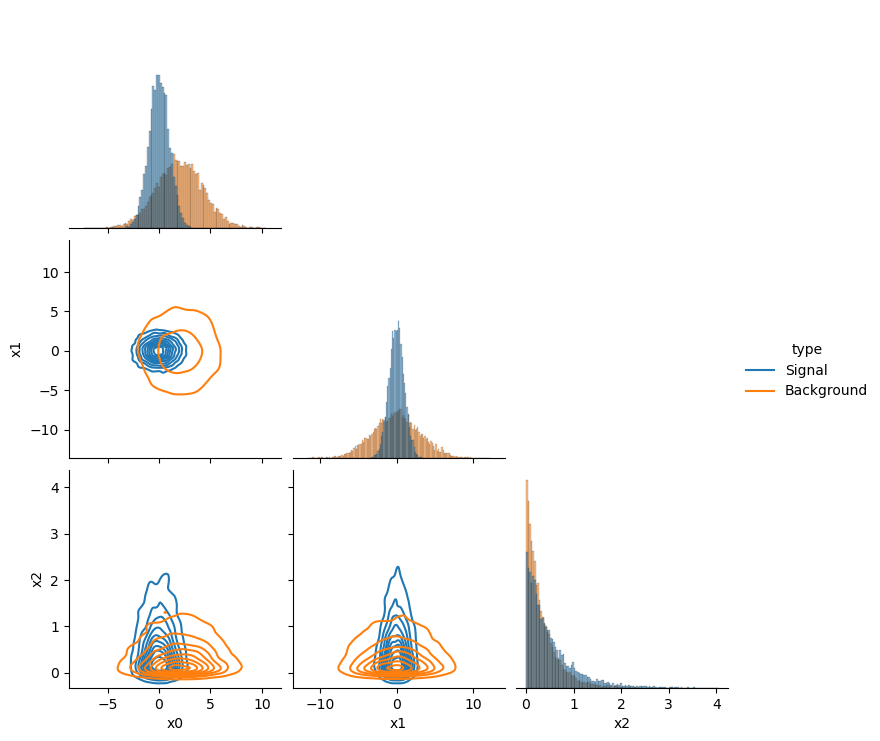

In [6]:
# Plot distributions using seaborn package
df_s['type'] = 'Signal'
df_b['type'] = 'Background'
df_tot = pd.concat([df_s,df_b])
g = seaborn.pairplot(df_tot, hue="type", 
                 diag_kind='hist', kind="kde", 
                 vars=['x0','x1','x2'],
                 corner=True)

* Do the distributions match what you expect?

## Part 2: signal-vs-background classification
To extract the observed signal yield in real data, we use the simulation to construct a summary statistic that efficiently separates signal from background. Note in this example we could use the analytic likelihood directly, but in the real-world scenario this is not possible. In this section we will show two methods for constructing the summary statistic. The first method again requires that the true likelihood is known, but is used to define the "best-possible" solution to the classification problem (in the absence of nuisance parameters). The second method employs a neural network, which is the kind of technique we use in real LHC analyses.

### Optimal classifier: conditional-density-ratio
From the [Neyman-Pearson lemma](https://royalsocietypublishing.org/doi/10.1098/rsta.1933.0009) we know that the optimal classifier between two hypotheses (in the absence of nuisance parameters) is the conditional-density ratio.

$t(\mathbf{x}) = \Large\frac{f_s(\mathbf{x})}{f_s(\mathbf{x})+f_b(\mathbf{x})}$

We will use this as an upper bound to evaluate the performance of a neural network provided with the same classification task. It is important to note that this is only possible for this problem as the generating pdfs are known. In real-world analyses, we do not have this luxury due to the large number of latent features. As usual, it is easier to work with the log probabilities:

In [7]:
# Function to evaluate log-likelihood for any product of independent pdfs
def log_prob(events, distributions=[], dim_splitting=[]):
    log_prob_sum = torch.zeros(len(events))
    for i,d in enumerate(distributions):
        log_prob_sum += d.log_prob(events[:,dim_splitting[i]])
    return log_prob_sum

# Function to return the conditional density ratio for signal/background hypotheses
def optimal_classifier(events, pdfs):
    log_prob_s = log_prob(events, distributions=pdfs['sig'], dim_splitting=[[0,1],2])
    log_prob_b = log_prob(events, distributions=pdfs['bkg'], dim_splitting=[[0,1],2])
    log_dr = log_prob_s-log_prob_b
    opt_clf = torch.exp(log_dr) / (1 + torch.exp(log_dr))
    return opt_clf

At this point we will generate more data points ("events" in particle physics lingo) and check the distributions of the optimal classifier for signal and background. These are the same events we will use for training the neural networks.

In [8]:
N_events = 100000
features = ['x0','x1','x2']
df_s, df_b = generate_simulation(pdfs, N=N_events)
events_s = torch.Tensor(df_s[features].to_numpy())
events_b = torch.Tensor(df_b[features].to_numpy())
df_s['opt_clf'] = optimal_classifier(events_s, pdfs)
df_b['opt_clf'] = optimal_classifier(events_b, pdfs)

Text(0, 0.5, 'Events')

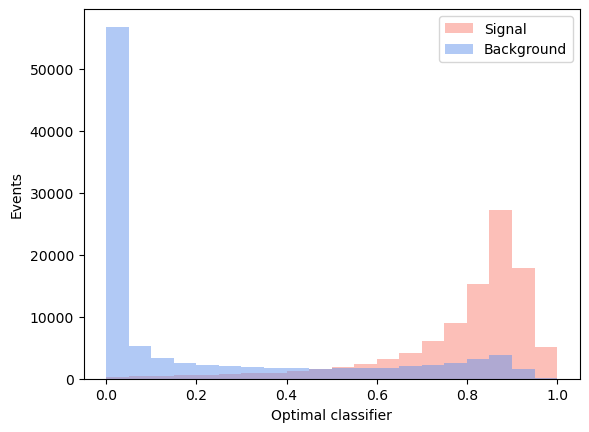

In [9]:
fig, ax = plt.subplots()
hs = ax.hist(df_s['opt_clf'], bins=20, range=(0,1), color='salmon', alpha=0.5, label="Signal")
hb = ax.hist(df_b['opt_clf'], bins=20, range=(0,1), color='cornflowerblue', alpha=0.5, label="Background")
ax.legend(loc='best')
ax.set_xlabel("Optimal classifier")
ax.set_ylabel("Events")

We can see that the conditional density ratio has done a good job at separating the simulated signal and background events.

### Neural network: binary cross entropy
Now we will use a neural network for the same binary classification problem. For this task we will use a network with two hidden layers of 100 nodes each. The hyperparameters for training are defined in the block below.

In [10]:
# Training hyperparameters
train_hp = {
    "lr":0.0001,
    "batch_size":10000,
    "N_epochs":100,
    "seed":0
}

# Set seed
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(train_hp['seed'])

In [11]:
class Net(nn.Module):
    def __init__(self, n_features=3, nodes=[100,100], output_nodes=2):
        super(Net, self).__init__()
        # Build network
        n_nodes = [n_features] + nodes + [output_nodes]
        self.layers = nn.ModuleList()
        for i in range(len(n_nodes)-1):
            self.layers.append(nn.Linear(n_nodes[i], n_nodes[i+1]))
            self.layers.append(nn.ReLU())

    def forward(self, x):
        out = self.layers[0](x)
        for layer in self.layers[1:]:
            out = layer(out)
        # Apply softmax
        return torch.softmax(out, dim=1)

In [12]:
# Function to train network with cross entropy loss
def train_network_cross_entropy(model, train_df, test_df, features=['x0','x1','x2'], train_hp={}):
    optimiser = torch.optim.Adam(model.parameters(), lr=train_hp["lr"])

    X_train = train_df[features].to_numpy()
    X_test = test_df[features].to_numpy()
    y_train = train_df[["is_bkg","is_sig"]].to_numpy()
    y_test = test_df[["is_bkg","is_sig"]].to_numpy()

    ce_loss = nn.CrossEntropyLoss()
    train_loss, test_loss = [], []

    print(">> Training...")
    with tqdm(range(train_hp["N_epochs"])) as t:
        for i_epoch in t:
            model.train()

            # "get_batches": function defined in statml_tools.py to separate the training data into batches
            batch_gen = get_batches([X_train, y_train], batch_size=train_hp['batch_size'],
                                    randomise=True, include_remainder=False
                                   )
            
            for X_tensor, y_tensor in batch_gen:
                optimiser.zero_grad()
                output = model(X_tensor)
                loss = ce_loss(output, y_tensor)
                loss.backward()
                optimiser.step()

            model.eval()
            # "get_total_loss": function defined in statml_tools.py to evaluate the network in batches (useful for large datasets)
            train_loss.append(get_total_loss(model, ce_loss, X_train, y_train))
            test_loss.append(get_total_loss(model, ce_loss, X_test, y_test))
            t.set_postfix(train_loss=train_loss[-1], test_loss=test_loss[-1])

    print(">> Training finished")
    model.eval()

    return model, train_loss, test_loss

In [13]:
# Do test-train split for simulated data
sig_train, sig_test = train_test_split(df_s, test_size=0.5, random_state=train_hp['seed'])
bkg_train, bkg_test = train_test_split(df_b, test_size=0.5, random_state=train_hp['seed'])
train_df = pd.concat([sig_train, bkg_train]).sample(frac=1)
test_df = pd.concat([sig_test, bkg_test]).sample(frac=1)

In [14]:
# Initialise network
model_bce = Net(n_features=3, nodes=[100,100], output_nodes=2)

In [15]:
# Train network
model_bce, train_loss_bce, test_loss_bce = train_network_cross_entropy(model_bce, train_df, test_df, train_hp=train_hp)

>> Training...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s, test_loss=0.453, train_loss=0.454]

>> Training finished


Now the network has been trained (should take ~1 minutes with the current set of hyperparameters), let's check the performance. We will do this in two ways:
* Plotting the train and test loss as a function of the number of epochs. Have we reached the plateau? Is there any sign of overtraining?
* Plot a histogram of the network output. Does the network show a good separation of simulated signal and background events?

Text(0, 0.5, 'BCE loss')

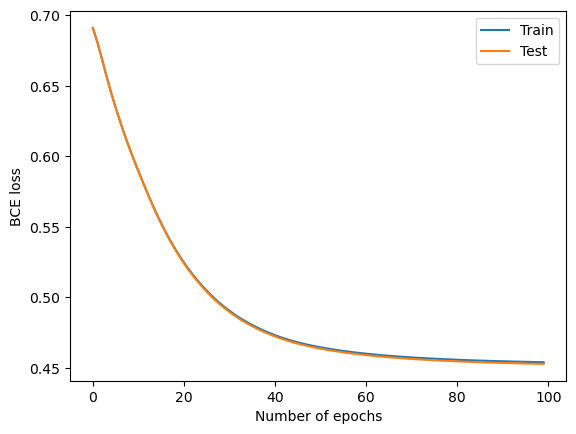

In [16]:
# Plot loss function curves
fig, ax = plt.subplots()
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), train_loss_bce, label="Train")
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), test_loss_bce, label="Test")
ax.legend(loc='best')
ax.set_xlabel("Number of epochs")
ax.set_ylabel("BCE loss")

In [17]:
# Add BCE network output to dataframes 
df_s['nn_bce'] = model_bce(torch.tensor(df_s[['x0','x1','x2']].to_numpy())).T[1].detach()
df_b['nn_bce'] = model_bce(torch.tensor(df_b[['x0','x1','x2']].to_numpy())).T[1].detach()

Text(0, 0.5, 'Events')

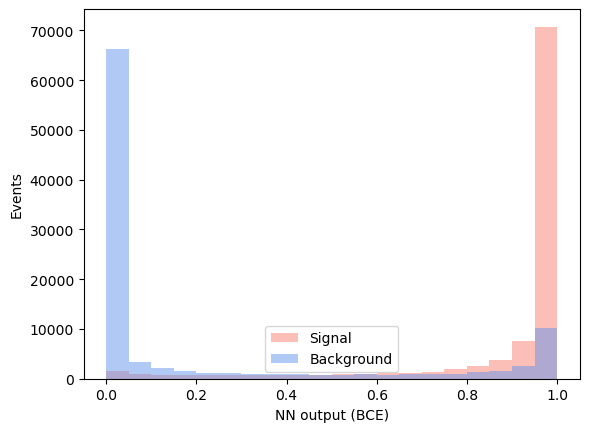

In [18]:
# And plot histograms of network output
fig, ax = plt.subplots()
hs = ax.hist(df_s['nn_bce'], bins=20, range=(0,1), color='salmon', alpha=0.5, label="Signal")
hb = ax.hist(df_b['nn_bce'], bins=20, range=(0,1), color='cornflowerblue', alpha=0.5, label="Background")
ax.legend(loc='best')
ax.set_xlabel("NN output (BCE)")
ax.set_ylabel("Events")

## Part 3: extracting the signal rate
Both the conditional density ratio (`opt_clf`) and the NN classifier (`nn_bce`) show good discrimination between signal and background events. In this section we will use these summary statistics to infer the signal yield, $s$, and its respective confidence interval. The size of the confidence interval allows us to compare the power of the summary statistics.

For inference in particle physics analyses, we typically **histogram** the summary statistic as the underlying probability density is not known. This simplifies the inference problem as the likelhood is then defined as the product of Poisson probabilities in each bin. The relative fraction of signal and background events landing in each bin, $i$, of the distribution is estimated from the simulation. We can write the likelihood as:

\begin{equation}
\mathcal{L}(\mathcal{D}|\theta) = \prod^m_i \rm{Pois}(n_i|s_i(\theta)+b_i(\theta)) = \prod_i (s_i(\theta)+b_i(\theta))^{n_i} e^{-(s_i(\theta)+b_i(\theta))}/n_i!
\end{equation}

Here the dataset, $\mathcal{D}$, comprises of $n_i$ events observed in bin $i$ of the summary statistic histogram. For clarity, these are the events we observe in real data at the LHC. The parameters of the fitted model, $\theta$, affect the signal and background yield estimates in each bin.

At this point, I want to introduce the concept of an "[Asimov dataset](https://arxiv.org/pdf/1007.1727.pdf)". We define the Asimov dataset as the dataset one obtains for fixed values of the model parameters in the absence of statistical fluctuations. In other words the number of events in bin $i$, is equal to the expected signal-plus-background yield in that bin,

$n_i(\theta_{\rm{init}}) = s_i(\theta_{\rm{init}}) + b_i(\theta_{\rm{init}})$,

shown here for $\theta = \theta_{\rm{init}}$. This is an extremely useful tool for evaluating the expected sensitivity of our measurement (or more formally the median experimental sensitivity). We will define the Asimov dataset using the following notation:

$\mathcal{D} \rightarrow \mathcal{A} = {n_i(\theta_{\rm{init}})}$.

In this section we will be working with two parameters: $\theta = (s,b)$, which are the total signal and background yields. To get the yield estimates in each bin of the histogram we use the simulation to estimate the binned probability density distributions, $\rho_s$ and $\rho_b$,

$s_i(\theta) = s * \rho_s$

$b_i(\theta) = b * \rho_b$

As usual, we will work with the negative-log-likelihood (NLL) for inference. First we define a function to calculate the NLL at $\theta=(s,b)$ for an Asimov dataset defined at $\theta_{\rm{init}}$. Following from the likelihood expression above, the Asimov NLL can be writted as,

\begin{equation}
\rm{NLL}(\mathcal{A}|\theta) = -\sum_i n_i(\theta_{\rm{init}}) \ln{\big[s_i(\theta)+b_i(\theta)\big]} + (s_i(\theta)+b_i(\theta)) - \ln{\big[n_i!\big]}
\end{equation}
For inference we are only interested in the $\Delta$NLL so we can ignore the final term as it is a constant (independent of $\theta$) and therefore will cancel. It is important to do this for the Asimov dataset as the yields in each bin, $n_i(\theta_{\rm{init}})$, can take non-integer values, for which the factorial is ill-defined.

The following block of code defines the function to calculate the Asimov NLL at $\theta=(s,b)$ for an Asimov dataset defined at $\theta_{\rm{init}}$. Here `rho_s` and `rho_b` are the binned probability densities of the summary statistic for signal and background events, respectively, determined from the simulation.

In [19]:
# Function to calculate the negative-log-likelihood using the Asimov dataset
def NLL(s, b, theta_init, rho_s, rho_b):
    rho_s, rho_b = torch.tensor(rho_s), torch.tensor(rho_b)
    counts_exp = s*rho_s + b*rho_b
    asimov = theta_init['s']*rho_s + theta_init['b']*rho_b
    return -1*(asimov*torch.log(counts_exp)-counts_exp).sum()

The point which minimises the NLL is the best-fit value. By construction this will be at $\theta = \theta_{\rm{init}}$. To extract the confidence intervals we use the 2$\Delta$NLL curve as a function of the parameter of interest. The points where this curve crosses 2$\Delta$NLL = 1 define the 1$\sigma$ (68%) confidence interval. For convenience we define a function which converts an array of NLL values into an array of 2$\Delta$NLL values.

In [20]:
# Function to extract 2NLL from array of NLL values
def TwoDeltaNLL(x):
    x = np.array(x)
    return 2*(x-x.min())

For this tutorial we will consider the inference task where the background yield is known i.e. we fix b and calculate NLL for different values of s. We will use the following initial values for the parameters,

\begin{equation}
\theta_{\rm{init}} = (s_{\rm{init}},b_{\rm{init}}) = (50,1000)
\end{equation}

Let's now see how sensitive our summary statistics are. For this task we will use 5 bins ($m=5$) of equal width. Note this is by no means the optimal binning but it's a simple choice for this tutorial.

In [21]:
# Initialise theta (s = signal yield, b = background yield)
N_bins = 5
theta_init = {'s':50., 'b':1000.}

# Extract binned probability density histograms (rho_s and rho_b) for signal and background, for both optimal classifier and NN (BCE)
# To extract the density we must divide through by the total number of events (so that the total sum of histogram = 1)
counts_s, counts_b = {}, {}
for obs in ['opt_clf','nn_bce']:
    counts_s[obs] = np.histogram(df_s[obs], bins=N_bins, range=(0,1))[0]
    counts_s[obs] = counts_s[obs] / counts_s[obs].sum()
    counts_b[obs] = np.histogram(df_b[obs], bins=N_bins, range=(0,1))[0]
    counts_b[obs] = counts_b[obs] / counts_b[obs].sum()

We can plot the histograms (with the asimov dataset) if it helps you visualise the problem. The inference task amounts to varying the signal yield, s, and calculating the NLL.

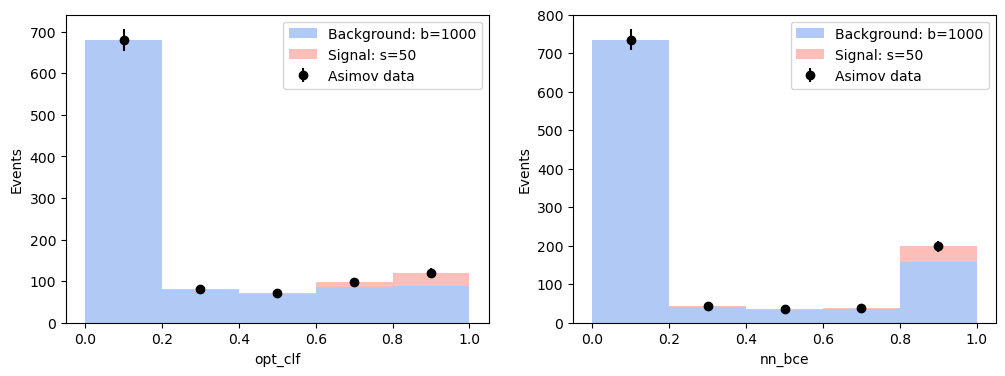

In [22]:
# And plot histograms of network output
fig, axs = plt.subplots(1,2, figsize=(12,4))
for i,obs in enumerate(['opt_clf','nn_bce']):
    # Signal and background estimates
    bottom = np.zeros(5)
    axs[i].bar([0.1,0.3,0.5,0.7,0.9], theta_init['b']*counts_b[obs], bottom=bottom, width=0.2, color='cornflowerblue', label='Background: b=1000', alpha=0.5)
    bottom += theta_init['b']*counts_b[obs]
    axs[i].bar([0.1,0.3,0.5,0.7,0.9], theta_init['s']*counts_s[obs], bottom=bottom, width=0.2, color='salmon', label='Signal: s=50', alpha=0.5)
    # Data points
    asimov = theta_init['s']*counts_s[obs]+theta_init['b']*counts_b[obs]
    axs[i].errorbar([0.1,0.3,0.5,0.7,0.9], asimov, yerr=asimov**0.5, marker='o', ls='None', color='black', label='Asimov data')
    axs[i].legend(loc='best')
    axs[i].set_xlabel(obs)
    axs[i].set_ylabel("Events")

In [23]:
# Calculate NLL scanning over signal yield, s, between 0 and 100
# Fix bkg yield to initial value
s_vals = np.linspace(0,100,101)
b = theta_init['b'] # = 1000
nll = {}
for obs in ['opt_clf','nn_bce']: 
    nll[obs] = []
    
for s in s_vals:
    for obs in ['opt_clf','nn_bce']:
        nll[obs].append(NLL(s, b, theta_init, counts_s[obs], counts_b[obs]))

/tmp/ipykernel_87643/229281823.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return "$%.2f^{+%.2f}_{-%.2f}$"%(val[0],abs(val[1]),abs(val[2]))


Text(0, 0.5, '2$\\Delta$NLL')

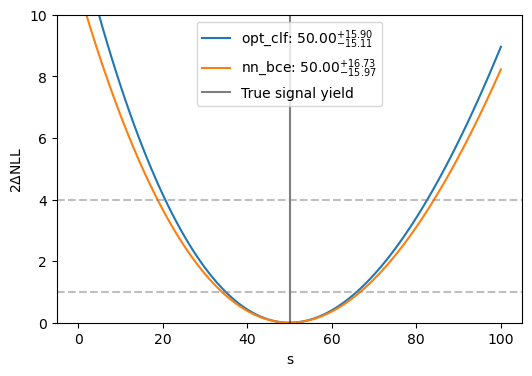

In [24]:
# Plot NLL curves for both summary statistics
labels = {}
for obs in ['opt_clf','nn_bce']:
    vals = find_crossings((s_vals,TwoDeltaNLL(nll[obs])),1.)
    labels[obs] = f"{obs}: {add_val_label(vals)}"

fig, ax = plt.subplots(figsize=(6,4))
for obs in ['opt_clf','nn_bce']:
    ax.plot(s_vals, TwoDeltaNLL(nll[obs]), label=labels[obs])
ax.axvline(theta_init['s'], label="True signal yield", color='black', alpha=0.5)
ax.axhline(1, color='grey', alpha=0.5, ls='--')
ax.axhline(4, color='grey', alpha=0.5, ls='--')
ax.set_ylim(0,10)
ax.legend(loc='best')
ax.set_xlabel("s")
ax.set_ylabel("2$\\Delta$NLL")

As stated above, the value of s which minimises the 2$\Delta$NLL is the best-fit value. By construction this will be at $s = s_{\rm{init}}$. The confidence intervals on s are defined by the points where the curves cross 2$\Delta$NLL = 1. We have used a function defined in `statml_tools.py` to extract the 1$\sigma$ (68%) confidence intervals which are displayed in the legend. As you can see for this task, the neural network does almost as good a job as the optimal classifier!

## Part 4: introduction of nuisance parameters

So far so good. We can extract the signal yield (of e.g. Higgs boson events) when presented with a mixture of signal and background events by constructing a summary statistic which discriminates between the two classes. If only things were this simple...

In reality there are many underlying (latent) features which are not known. Yet they impact the data we observe and thus our measurements. These features are things like:

* Detector energy calibration and resolution
* Patterns of energy showers produced as particles move through the detector
* Underlying theoretical models of proton collision

To account for these effects we introduce model parameters which are unspecified but must be accounted for when performing inference on the parameters of interest. These are called **nuisance parameters**, and their effect must be built into our model. In this section we shall see that the inference power of our learned summary statistic (`nn_bce`) decreases when nuisance parameters are taken into account in the inference step. 

Let's introduce a single nuisance parameter, $r$, which changes the scale (loc) of the normal distribution of $x_0$ for background events,

$f_b(\mathbf{x}) = \mathcal{N}\Big(\,(x_0,x_1)\,\Big|\,(2+r,0),\, \begin{bmatrix}5 & 0 \\ 0 & 9 \end{bmatrix}\Big) \rm{Exp}(x_2|3)$

For this example, we can define a simple mapping which transforms an event simulated under one $r$ hypotheses ($r_{\rm{init}}$) to another ($r$):

$x_0 \longrightarrow x_0 + r - r_{\rm{init}}$

Note, the events simulated in the previous sections are for $r_{\rm{init}}=0$. 

The ability to write down a (differentiable) mapping to describe how a data point changes under the influence of a model parameter is known as a **differentiable simulation**. If this is not possible, then we use variational methods to describe how a simulated dataset varies as a function of the nuisance parameters. This is slightly more involved but can be used for the inference-aware method discussed in the next section. In any case, let's stick to this simple example with a differentiable mapping for now.

We begin by writing down a function which performs the mapping defined above for dataset, X:

In [25]:
# Function to transform background events
def transform_X(X, theta_init, r):
    x_prime_0 = X[:,0] + r - theta_init['r']
    x_prime_1 = X[:,1]
    x_prime_2 = X[:,2]
    return torch.stack([x_prime_0,x_prime_1,x_prime_2], dim=1)

Let's see how the $x_0$ distribution for background events changes for different values of r:

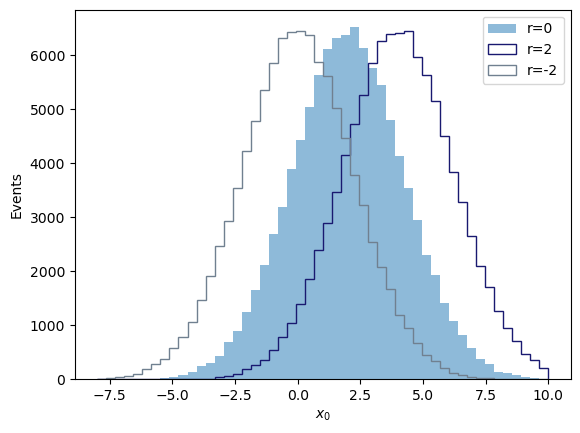

In [26]:
theta_init = {'s':50., 'b':1000., 'r':0.}
features = ['x0','x1','x2']
X_b = torch.tensor(df_b[features].to_numpy())

fig, ax = plt.subplots()
ax.hist(X_b.T[0], bins=50, range=(-8,10), alpha=0.5, label="r=0")
ax.hist(transform_X(X_b,theta_init,2).T[0], bins=50, range=(-8,10), color='midnightblue', histtype='step', label="r=2")
ax.hist(transform_X(X_b,theta_init,-2).T[0], bins=50, range=(-8,10), color='slategrey', histtype='step', label="r=-2")
ax.set_xlabel("$x_0$")
ax.set_ylabel("Events")
ax.legend(loc='best')

To infer the signal yield, we are using our learnt summary statistic from the neural network with BCE loss (`nn_bce`). Let's study how susceptible our summary statistic distribution is to changes in $r$. The larger the variation in the summary statistic shape, the larger the impact of the nuisance parameter in our measurement. Let's look at the `nn_bce` distribution for different values of r:

Text(0, 0.5, 'Events')

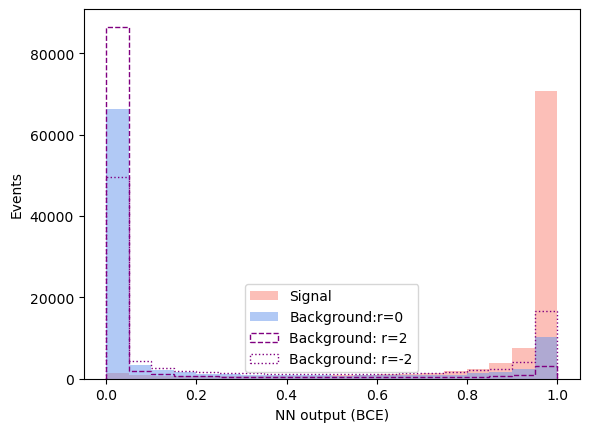

In [27]:
fig, ax = plt.subplots()
ax.hist(df_s['nn_bce'], bins=20, range=(0,1), color='salmon', alpha=0.5, label="Signal")
ax.hist(df_b['nn_bce'], bins=20, range=(0,1), color='cornflowerblue', alpha=0.5, label="Background:r=0")
# Extract NN outputs for transformed background events
nn_bce_bkg_r2 = model_bce(transform_X(torch.tensor(df_b[features].to_numpy()),theta_init,2)).T[1].detach()
nn_bce_bkg_rm2 = model_bce(transform_X(torch.tensor(df_b[features].to_numpy()),theta_init,-2)).T[1].detach()
ax.hist(nn_bce_bkg_r2, bins=20, range=(0,1), color='purple', label="Background: r=2", histtype='step', ls='dashed')
ax.hist(nn_bce_bkg_rm2, bins=20, range=(0,1), color='purple', label="Background: r=-2", histtype='step', ls='dotted')
ax.legend(loc='best')
ax.set_xlabel("NN output (BCE)")
ax.set_ylabel("Events")

The background NN output distribution changes significantly with $r$, especially in the bin with the largest signal yield. We can tell already that this will have a dramatic impact on the inference of the signal yield, $s$. Let's now show this explicitly.

As before we define the likelihood according to the product of Poisson terms for each histogram bin. The Asimov NLL is defined as (dropping the constant term):

\begin{equation}
\rm{NLL}(\mathcal{A}|\theta) = -\sum_i n_i(\theta_{\rm{init}}) \ln{\big[s_i(\theta)+b_i(\theta)\big]} + (s_i(\theta)+b_i(\theta))
\end{equation}

where crucially $\theta=(s,b,r)$ now includes $r$, and we are using $\theta_{\rm{init}} = (s_{\rm{init}},b_{\rm{init}},r_{\rm{init}}) = (50,1000,0)$.

For inference, we need to model how the binned probability density distribution for background events varies as a function of $r$ i.e. find $h_b(r)$. We can do this by interpolating the yields in each bin...

Text(0.5, 0, 'r')

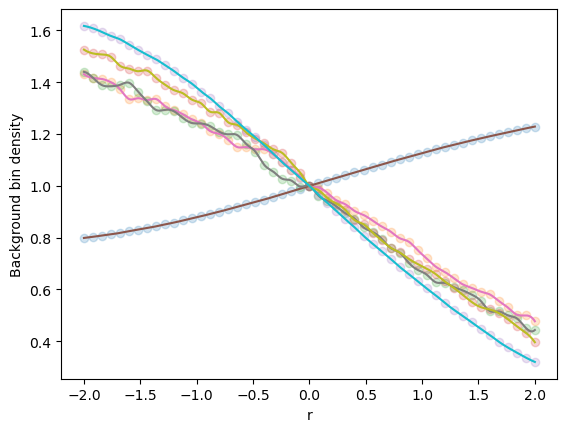

In [28]:
# Calculate interpolated histogram for background events
X_b = torch.Tensor(df_b[features].to_numpy())
r_vals = np.linspace(-2,2,51)

# Define signal counts
counts_s = counts_s['nn_bce']

counts_b = []
for r in r_vals:
    X_b_shift = transform_X(X_b,theta_init,r)
    y = model_bce(X_b_shift).T[1].detach()
    c = np.histogram(y, bins=N_bins, range=(0,1))[0]
    c = c / c.sum()
    counts_b.append(c)
        
# Use scipy package for interpolation of bin densities
counts_b_interp = interp1d(r_vals, np.array(counts_b).T, kind='cubic')

# Plot interpolation relative to histogram at r=0
counts_b_init = counts_b_interp(0)
r_vals_spline = np.linspace(-2,2,1000)
counts_b_spline = []
for r in r_vals_spline: counts_b_spline.append(counts_b_interp(r))

fig, ax = plt.subplots()
ax.plot(r_vals,counts_b/counts_b_init, ls='None', marker='o', alpha=0.2)
ax.plot(r_vals_spline,counts_b_spline/counts_b_init)
ax.set_ylabel("Background bin density")
ax.set_xlabel("r")

This plot shows the background density in each of the five ($m=5$) NN output bins as a function of $r$, relative to the densities at $r=0$. Let's now redefine our NLL function to take $r$ as an input, as well as the interpolated background histogram, `rho_b(r)`. We place $r$ as the first argument in the function, as this is necessary for the minimization of the profiled likelihood at the end of this section.

In [29]:
# NLL defined with nuisance params and rho_b(r) is now an interpolated bkg histogram
def NLL(params, s, b, theta_init, rho_s, rho_b):
    r = params[0]
    rho_s, rho_b, rho_b_asimov = torch.tensor(rho_s), torch.tensor(rho_b(r)), torch.tensor(rho_b(theta_init['r']))
    counts_exp = s*rho_s + b*rho_b
    asimov = theta_init['s']*rho_s + theta_init['b']*rho_b_asimov
    return -1*(asimov*torch.log(counts_exp)-counts_exp).sum()

Let's calculate the 2$\Delta$NLL in the $(s,r)$ plane. The contours at which 2$\Delta$NLL = 2.3 and 5.99 correspond to the 68% and 95% confidence intervals.

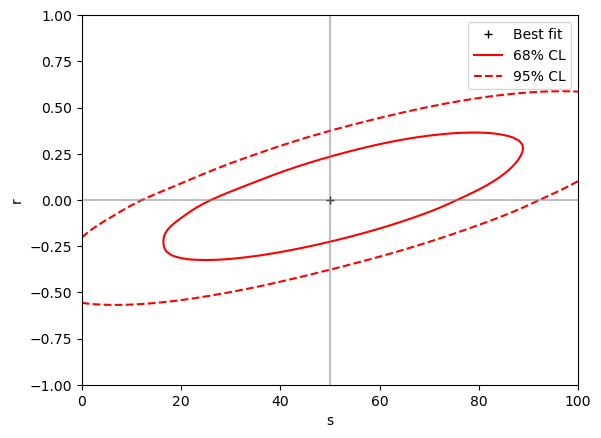

In [30]:
s = np.linspace(0,100,101)
r = np.linspace(-1,1,101)
S,R = np.meshgrid(s,r)
Z = []
for i in range(len(S)):
    z = []
    for j in range(len(S[i])):
        sval,rval = S[i][j], R[i][j]
        z.append(NLL(np.array([rval]), sval, 1000, theta_init, counts_s, counts_b_interp))
    Z.append(z)
nll = np.array(Z)

fig, ax = plt.subplots()
cs = ax.contour(S,R,TwoDeltaNLL(nll), levels=[2.3,5.99], colors=['red','red'], linestyles=['solid','dashed'])
i_bf, j_bf = np.unravel_index(TwoDeltaNLL(nll).argmin(), TwoDeltaNLL(nll).shape)
ax.plot(S[i_bf][j_bf], R[i_bf][j_bf], marker='+', color='black', label='Best fit', ls='None')
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([],[], color='red', ls='solid'))
handles.append(plt.Line2D([],[], color='red', ls='dashed'))
labels.append("68% CL")
labels.append("95% CL")
ax.legend(handles, labels, loc='best')
ax.set_xlabel("s")
ax.set_ylabel("r")
ax.axhline(theta_init['r'], color='grey', alpha=0.5)
ax.axvline(theta_init['s'], color='grey', alpha=0.5)

We immediately see a strong correlation between $s$ and $r$, that impacts our sensitivity to the signal yield. This will be even more apparent if we look at the profiled likelihood (sorry Bayesians, you could also marginalise over $r$). For the profiled likelihood we calculate the NLL as a function of $s$, but minimise over the nuisance parameter(s) for each point in the fit i.e. we allow $r$ to float in the fit. Let's use the `scipy.optimize` package to calculate the profiled likelihood. Note, we will also keep track of the value of $r$ in the likelihood scan.

/tmp/ipykernel_87643/229281823.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return "$%.2f^{+%.2f}_{-%.2f}$"%(val[0],abs(val[1]),abs(val[2]))


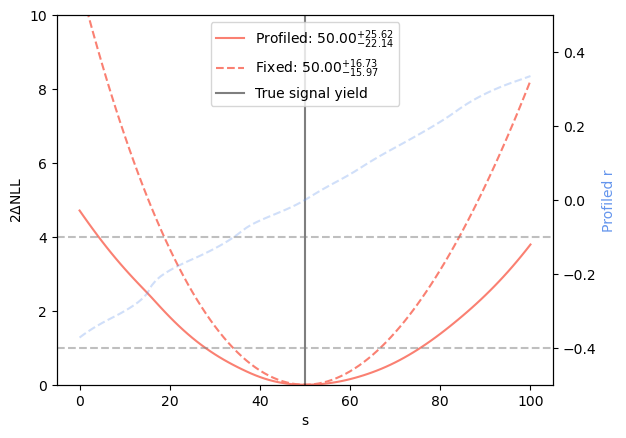

In [31]:
# Initialise nuisance parameters (r=0)
params = np.array([0.])

# Calculate profiled NLL for different values of s
# We will also track the value of NLL but fixing r=0, this is equivalent to the results in part 3
s_vals = np.linspace(0,100,101)
nll_prof, r_prof = [], []
nll_fixed = []
for s in s_vals:
    res = minimize(NLL, params, args=(s, 1000, theta_init, counts_s, counts_b_interp))
    nll_prof.append(res.fun)
    r_prof.append(res.x[0])
    nll_fixed.append(NLL(params, s, 1000, theta_init, counts_s, counts_b_interp))
    
twoDeltaNLL_prof = TwoDeltaNLL(nll_prof)
twoDeltaNLL_fixed = TwoDeltaNLL(nll_fixed)

vals_prof = find_crossings((s_vals,twoDeltaNLL_prof),1.)
label_prof = "Profiled: " + add_val_label(vals_prof)
vals_fixed = find_crossings((s_vals,twoDeltaNLL_fixed),1.)
label_fixed = "Fixed: " + add_val_label(vals_fixed)

fig, ax = plt.subplots()
ax.plot(s_vals,twoDeltaNLL_prof, label=label_prof, color='salmon')
ax.plot(s_vals,twoDeltaNLL_fixed, label=label_fixed, color='salmon', ls='--')
ax.axvline(theta_init['s'], label="True signal yield", color='black', alpha=0.5)
ax.axhline(1, color='grey', alpha=0.5, ls='--')
ax.axhline(4, color='grey', alpha=0.5, ls='--')
ax.set_ylim(0,10)
ax.set_xlabel("s")
ax.set_ylabel("2$\Delta$NLL")
axr = ax.twinx()
axr.plot(s_vals,r_prof, color='cornflowerblue', ls='--', alpha=0.3)
axr.set_ylabel("Profiled r", color='cornflowerblue')
axr.set_ylim(-0.5,0.5)
ax.legend(loc='best')

The confidence interval on $s$ has increased significantly when including the nuisance parameter, $r$, in the inference step. Our sensitivity has dropped by around 50%!

## Part 5: inference-aware learning
In Section 4 we saw that the summary statistic from a NN trained with a BCE loss is susceptible to variations in the nuisance parameter, $r$. This has a dramatic impact on our sensitivity to the signal yield, $s$, when performing the full inference.

Ideally we want to construct a summary statistic that does not diminish in power when we include the impact of nuisance parameters in the inference.

This is where **inference-aware optimisation** enters the stage. Rather than using the BCE loss, we will construct a loss function which directly approximates the 68% confidence interval on s. As the network trains (SGD on loss) we will directly be minimizing the 68% confidence interval on s, importantly whilst accounting for $r$.

The network, $f(x;\phi)$ is constructed with $m$=5 output nodes. 

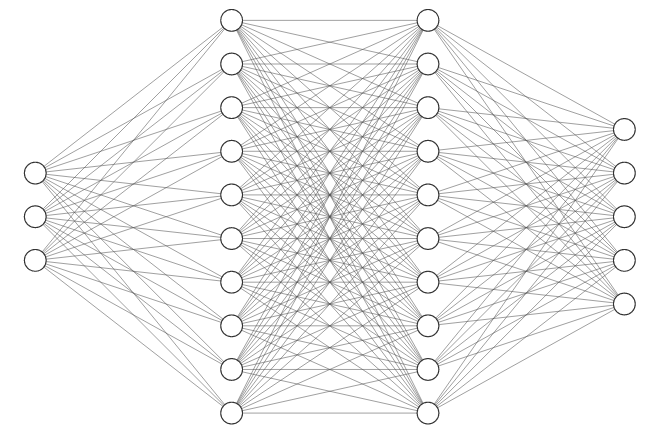

We define a (differentiable) summary statistic using the softmax function with temperature, $\tau$, which is to be optimised via SGD on $\phi$.

\begin{equation*}
        t_i(\mathcal{D};\phi) = \sum_{x\in\mathcal{D}} \frac{e^{f_i(x;\phi)/\tau}}{\sum^m_{j=0} e^{f_j(x;\phi)/\tau}}
\end{equation*}

This provides a histogram of $m$ bins, labelled by index $i$. In much the same way we can write a likelihood using the product of Poisson terms in each bin as,

\begin{equation*}
        L_{\mathcal{A}}(s,b,r;\phi) = \prod^m_{i=0} {\rm{Pois}}(n_i | s\rho_{s,i}(\phi) + b\rho_{b,i}(r;\phi)),
\end{equation*}

where $\rho$ represents the binned probability density in the summary statistic. We can calculate this over events (in a minibatch) using the `torch.mean` function. This likelihood is calculated for an Asimov dataset, $\mathcal{A}$, where the values of the parameters, $\theta$ are set to $\theta_{\rm{init}}$:

\begin{equation*}
    n_i = s_{\rm{init}}\rho_{s,i}(\phi) + b_{\rm{init}}\rho_{b,i}(r_{\rm{init}};\phi)
\end{equation*}  

The following block of code first defines a function (`NLL_ia`) to calculate the negative log-likelihood given the network output. This is much the same as the previous function definitions which calculate NLL, except the binned probability densities are calculated on the fly given the network output, `y=model(x)`.

We then define the inference-aware loss function. As everything has been defined in a differentiable way (with stored gradients), we can use the `torch.func.hessian` method to evaluate the Fisher-information matrix for `NLL_ia` as a function of the arguments, $(s,r)$.

\begin{equation*}
    \mathcal{I}_{ij}(\theta_{\rm{init}};\phi) = \frac{\partial^2}{\partial\theta_i\partial\theta_j}\Big(- \ln{L_{\mathcal{A}}(\theta;\phi)\Big)}\Bigg|_{\theta=\theta_{\rm{init}}}
\end{equation*}

The scalar value returned from the `InferenceAwareLoss` function is directly the approximate uncertainty in the parameter of interest, s. 

\begin{equation*}
        \mathcal{L}(\phi) = \sqrt{\mathcal{I}^{-1}_{00}(\theta_{\rm{init}};\phi)} = \sqrt{\text{Var}(s;\phi)}
\end{equation*}



Take some time to look at this code and understand how the training works.

In [32]:
def hess_to_tensor(H):
    hess_elements = []
    for i in range(len(H)):
        for j in range(len(H)):
            hess_elements.append(H[i][j].reshape(1))
    return torch.cat(hess_elements).reshape(len(H),len(H))

def NLL_ia(s, b, r, theta_init, X, label, model):
    # Background asimov
    X_b = X[label==0]
    y_b_asimov = model(X_b)
    counts_b_asimov = torch.mean(y_b_asimov, axis=0)

    # Background at (r,lambda)
    X_b_shift = transform_X(X_b, theta_init, r)
    y_b = model(X_b_shift)
    counts_b = torch.mean(y_b, axis=0)

    # Signal
    X_s = X[label==1]
    y_s = model(X_s)
    counts_s = torch.mean(y_s, axis=0)
    
    counts_exp = s*counts_s + b*counts_b
    asimov = theta_init['s']*counts_s + theta_init['b']*counts_b_asimov
    return -1*(asimov*torch.log(counts_exp)-counts_exp).sum()

def InferenceAwareLoss(X, label, model, theta_init, active_args=0):
    # Define parameters
    s = torch.tensor(theta_init['s'], requires_grad=True)
    b = torch.tensor(theta_init['b'], requires_grad=True)
    r = torch.tensor(theta_init['r'], requires_grad=True)

    # Calculate fisher information: hessian of NLL function w.r.t active_args
    hess = torch.func.hessian(NLL_ia,active_args)(s, b, r, theta_init, X, label, model)
    
    if active_args == 0:
        return (1/hess)**0.5
    else:
        return torch.inverse(hess_to_tensor(hess))[0][0]**0.5 

Now for the training. The following set of hyperparameters leads to a sensible result for this particular problem. For more complex inference tasks you may need to change these values (including the number of output nodes/histogram bins, m).

The inference-aware network architecture is defined below, which has a tuneable parameter to change the temperature, $\tau$ of the softmax function. This value should be small enough so that the softmax is a good approximation of the argmax function (which must be used for the final inference), but big enough so that the network has sensible gradients for training. We set $\tau=0.1$ for this task, which gives a good performance.

In [33]:
# Training hyperparameters
train_hp = {
    "lr":1e-4,
    "batch_size":2000,
    "N_epochs":100,
    "seed":0
}

# Set seed
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seed(train_hp['seed'])

In [34]:
class NetInferenceAware(nn.Module):
    def __init__(self, n_features=3, nodes=[100,100], output_nodes=5, temp=0.1):
        super(NetInferenceAware, self).__init__()
        self.temperature = temp
        # Build network
        n_nodes = [n_features] + nodes + [output_nodes]
        self.layers = nn.ModuleList()
        for i in range(len(n_nodes)-1):
            self.layers.append(nn.Linear(n_nodes[i], n_nodes[i+1]))
            self.layers.append(nn.ReLU())

    def forward(self, x):
        out = self.layers[0](x)
        for layer in self.layers[1:]:
            out = layer(out)
        # Apply softmax with temperature
        out = out / self.temperature
        return torch.softmax(out, dim=1)

    # To evaluate with effective argmax set temp=0.0001
    def set_temperature(self, temp):
        self.temperature = temp

In [35]:
# Train network
def train_network_inference_aware(model, train_df, test_df, theta_init, features=['x0','x1','x2'], train_hp={}, active_args=0):
    optimiser = torch.optim.Adam(model.parameters(), lr=train_hp["lr"])

    X_train = train_df[features].to_numpy()
    X_test = test_df[features].to_numpy()
    label_train = train_df["is_sig"].to_numpy()
    label_test = test_df["is_sig"].to_numpy()

    ia_loss = lambda x, y, z: InferenceAwareLoss(x,y,z,theta_init,active_args=active_args)
    train_loss, test_loss = [], []

    print(">> Inference-Aware training...")
    with tqdm(range(train_hp["N_epochs"])) as t:
        for i_epoch in t:
            model.train()

            batch_gen = get_batches([X_train, label_train], batch_size=train_hp['batch_size'],
                                    randomise=True, include_remainder=False
                                   )
            
            for X_tensor, label_tensor in batch_gen:
                optimiser.zero_grad()
                loss = ia_loss(X_tensor, label_tensor, model)
                loss.backward()
                optimiser.step()

            model.eval()
            train_loss.append(ia_loss(torch.tensor(X_train), torch.tensor(label_train), model).detach())
            test_loss.append(ia_loss(torch.tensor(X_test), torch.tensor(label_test), model).detach())

            t.set_postfix(train_loss=train_loss[-1], test_loss=test_loss[-1])

    print(">> Training finished")
    model.eval()

    return model, train_loss, test_loss

Let's initiate the model and train...

In [36]:
model_ia = NetInferenceAware(temp=0.1)

In [37]:
model_ia, train_loss_ia, test_loss_ia = train_network_inference_aware(model_ia, train_df, test_df, theta_init, train_hp=train_hp, active_args=(0,2))

>> Inference-Aware training...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:26<00:00,  3.27s/it, test_loss=tensor(17.0153), train_loss=tensor(16.9542)]

>> Training finished


Again we will plot the loss function vs number of epochs in training. Now the y-axis represents directly the approximate uncertainty in the parameter of interest, s.

Following this we will build the interpolated background binned densities and plot the inference-aware network output.

Text(0, 0.5, 'Approximate uncertainty on s')

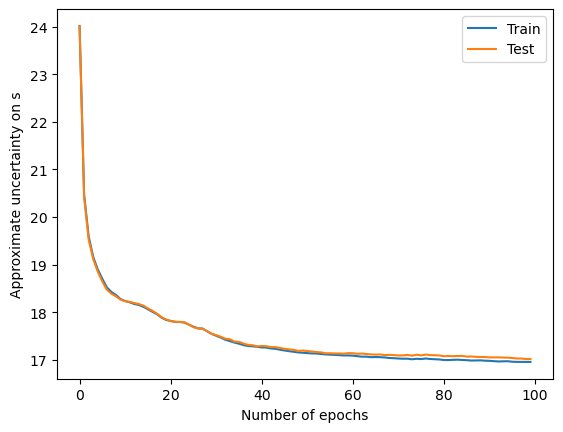

In [38]:
# Plot loss function curves
fig, ax = plt.subplots()
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), train_loss_ia, label="Train")
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), test_loss_ia, label="Test")
ax.legend(loc='best')
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Approximate uncertainty on s")

In [39]:
# Calculate interpolated histogram for background events for both BCE and Inference-Aware summary statistics
X_s = torch.Tensor(df_s[features].to_numpy())
X_b = torch.Tensor(df_b[features].to_numpy())
r_vals = np.linspace(-2,2,51)

counts_b = {}
counts_b['nn_bce'] = []
counts_b['nn_ia'] = []
for r in r_vals:
    X_b_shift = transform_X(X_b,theta_init,r)
    #BCE
    y = model_bce(X_b_shift).T[1].detach()
    c = np.histogram(y, bins=N_bins, range=(0,1))[0]
    c = c / c.sum()
    counts_b['nn_bce'].append(c)
    # IA
    y = model_ia(transform_X(X_b, theta_init, r))
    counts_b['nn_ia'].append(torch.mean(y, axis=0).detach())
        
# Use scipy package for interpolation of bin densities
counts_b_interp = {}
for obs in ['nn_bce','nn_ia']:
    counts_b_interp[obs] = interp1d(r_vals, np.array(counts_b[obs]).T, kind='cubic')

# Define signal counts
counts_s = {}
counts_s['nn_bce'] = np.histogram(df_s['nn_bce'], bins=N_bins, range=(0,1))[0]
counts_s['nn_bce'] = counts_s['nn_bce'] / counts_s['nn_bce'].sum()
counts_s['nn_ia'] = np.array(torch.mean(model_ia(X_s), axis=0).detach())

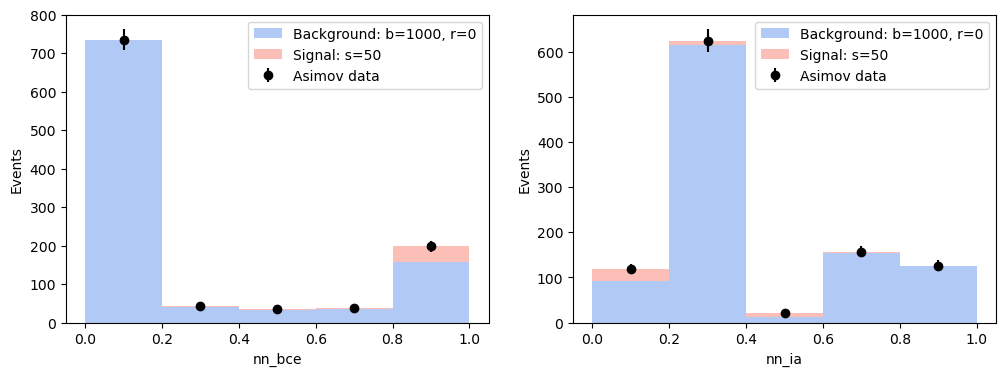

In [40]:
# Plot histograms of network outputs
fig, axs = plt.subplots(1,2, figsize=(12,4))
for i,obs in enumerate(['nn_bce','nn_ia']):
    # Signal and background estimates
    bottom = np.zeros(5)
    axs[i].bar([0.1,0.3,0.5,0.7,0.9], theta_init['b']*counts_b_interp[obs](0.), bottom=bottom, width=0.2, color='cornflowerblue', label='Background: b=1000, r=0', alpha=0.5)
    bottom += theta_init['b']*counts_b_interp[obs](0.)
    axs[i].bar([0.1,0.3,0.5,0.7,0.9], theta_init['s']*counts_s[obs], bottom=bottom, width=0.2, color='salmon', label='Signal: s=50', alpha=0.5)
    # Data points
    asimov = theta_init['s']*counts_s[obs]+theta_init['b']*counts_b_interp[obs](0.)
    axs[i].errorbar([0.1,0.3,0.5,0.7,0.9], asimov, yerr=asimov**0.5, marker='o', ls='None', color='black', label='Asimov data')
    axs[i].legend(loc='best')
    axs[i].set_xlabel(obs)
    axs[i].set_ylabel("Events")

It isn't clear by eye why this configuration would lead to a better constraint. So let's check this explicitly...

First we will look at the 2$\Delta$NLL in the $(s,r)$ plane. The contours at which 2$\Delta$NLL = 2.3 and 5.99 correspond to the 68% and 95% confidence intervals. We compare the result from the BCE network on the left, to the inference-aware network on the right. 

Text(0.5, 1.0, 'NN: Inference-Aware loss')

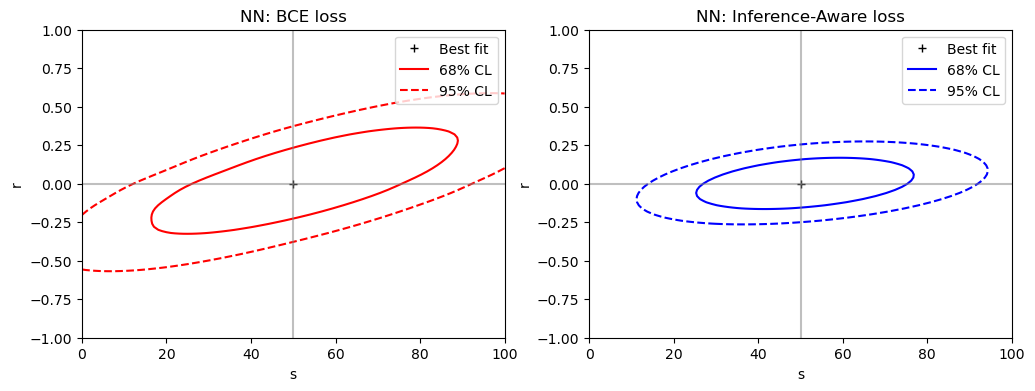

In [41]:
s = np.linspace(0,100,101)
r = np.linspace(-1,1,101)
S,R = np.meshgrid(s,r)
Z_bce, Z_ia = [], []
for i in range(len(S)):
    z_bce, z_ia = [], []
    for j in range(len(S[i])):
        sval,rval = S[i][j], R[i][j]
        z_bce.append(NLL(np.array([rval]), sval, 1000, theta_init, counts_s['nn_bce'], counts_b_interp['nn_bce']))
        z_ia.append(NLL(np.array([rval]), sval, 1000, theta_init, counts_s['nn_ia'], counts_b_interp['nn_ia']))
    Z_bce.append(z_bce)
    Z_ia.append(z_ia)
nll_bce = np.array(Z_bce)
nll_ia = np.array(Z_ia)

fig, axs = plt.subplots(1,2, figsize=(12,4))
cs = axs[0].contour(S,R,TwoDeltaNLL(nll_bce), levels=[2.3,5.99], colors=['red','red'], linestyles=['solid','dashed'])
i_bf, j_bf = np.unravel_index(TwoDeltaNLL(nll_bce).argmin(), TwoDeltaNLL(nll_bce).shape)
axs[0].plot(S[i_bf][j_bf], R[i_bf][j_bf], marker='+', color='black', label='Best fit', ls='None')
handles, labels = axs[0].get_legend_handles_labels()
handles.append(plt.Line2D([],[], color='red', ls='solid'))
handles.append(plt.Line2D([],[], color='red', ls='dashed'))
labels.append("68% CL")
labels.append("95% CL")
axs[0].legend(handles, labels, loc='best')
axs[0].set_xlabel("s")
axs[0].set_ylabel("r")
axs[0].axhline(theta_init['r'], color='grey', alpha=0.5)
axs[0].axvline(theta_init['s'], color='grey', alpha=0.5)
axs[0].set_title("NN: BCE loss")

cs = axs[1].contour(S,R,TwoDeltaNLL(nll_ia), levels=[2.3,5.99], colors=['blue','blue'], linestyles=['solid','dashed'])
i_bf, j_bf = np.unravel_index(TwoDeltaNLL(nll_ia).argmin(), TwoDeltaNLL(nll_ia).shape)
axs[1].plot(S[i_bf][j_bf], R[i_bf][j_bf], marker='+', color='black', label='Best fit', ls='None')
handles, labels = axs[1].get_legend_handles_labels()
handles.append(plt.Line2D([],[], color='blue', ls='solid'))
handles.append(plt.Line2D([],[], color='blue', ls='dashed'))
labels.append("68% CL")
labels.append("95% CL")
axs[1].legend(handles, labels, loc='best')
axs[1].set_xlabel("s")
axs[1].set_ylabel("r")
axs[1].axhline(theta_init['r'], color='grey', alpha=0.5)
axs[1].axvline(theta_init['s'], color='grey', alpha=0.5)
axs[1].set_title("NN: Inference-Aware loss")

The correlation between $s$ and $r$ has substantially reduced. This leads to a smaller confidence region for the inference-aware loss training.

To make the point absolutely clear, let's again look at the profiled 2$\Delta$NLL curves.

/tmp/ipykernel_87643/229281823.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return "$%.2f^{+%.2f}_{-%.2f}$"%(val[0],abs(val[1]),abs(val[2]))
/tmp/ipykernel_87643/229281823.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return "$%.2f^{+%.2f}_{-%.2f}$"%(val[0],abs(val[1]),abs(val[2]))


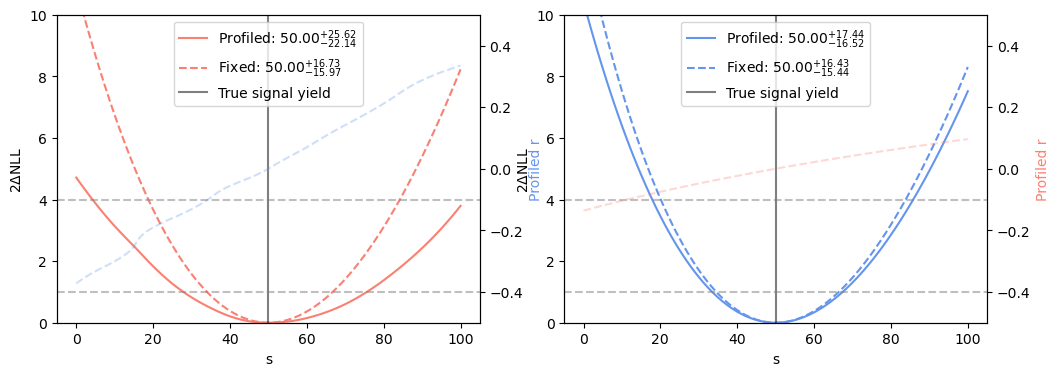

In [42]:
# Initialise nuisance parameters (r=0)
params = np.array([0.])

# Calculate profiled NLL for different values of s
# We will also track the value of NLL but fixing r=0, this is equivalent to the results in part 3
s_vals = np.linspace(0,100,101)
nll_prof, r_prof = {}, {}
nll_fixed = {}
twoDeltaNLL_prof, twoDeltaNLL_fixed = {}, {}
labels_prof, labels_fixed = {}, {}

for obs in ['nn_bce','nn_ia']:
    nll_prof[obs] = []
    r_prof[obs] = []
    nll_fixed[obs] = []
    for s in s_vals:
        res = minimize(NLL, params, args=(s, 1000, theta_init, counts_s[obs], counts_b_interp[obs]))
        nll_prof[obs].append(res.fun)
        r_prof[obs].append(res.x[0])
        nll_fixed[obs].append(NLL(params, s, 1000, theta_init, counts_s[obs], counts_b_interp[obs]))
    
    twoDeltaNLL_prof[obs] = TwoDeltaNLL(nll_prof[obs])
    twoDeltaNLL_fixed[obs] = TwoDeltaNLL(nll_fixed[obs])

    vals_prof = find_crossings((s_vals,twoDeltaNLL_prof[obs]),1.)
    labels_prof[obs] = "Profiled: " + add_val_label(vals_prof)
    vals_fixed = find_crossings((s_vals,twoDeltaNLL_fixed[obs]),1.)
    labels_fixed[obs] = "Fixed: " + add_val_label(vals_fixed)

fig, axs = plt.subplots(1,2, figsize=(12,4))
axr = {}
colors = ['salmon','cornflowerblue']
titles = ["NN: BCE loss", "NN: Inference-Aware loss"]
for i, obs in enumerate(['nn_bce','nn_ia']):
    axs[i].plot(s_vals,twoDeltaNLL_prof[obs], label=labels_prof[obs], color=colors[i])
    axs[i].plot(s_vals,twoDeltaNLL_fixed[obs], label=labels_fixed[obs], color=colors[i], ls='--')
    axs[i].axvline(theta_init['s'], label="True signal yield", color='black', alpha=0.5)
    axs[i].axhline(1, color='grey', alpha=0.5, ls='--')
    axs[i].axhline(4, color='grey', alpha=0.5, ls='--')
    axs[i].set_ylim(0,10)
    axs[i].set_xlabel("s")
    axs[i].set_ylabel("2$\Delta$NLL")
    axr[i] = axs[i].twinx()
    axr[i].plot(s_vals,r_prof[obs], color=colors[-(i+1)], ls='--', alpha=0.3)
    axr[i].set_ylabel("Profiled r", color=colors[-(i+1)])
    axr[i].set_ylim(-0.5,0.5)
    axs[i].legend(loc='best')

With the inference-aware training, our sensitivity to $s$ only decreases slightly with the introduction of the nuisance parameter $r$ (comparing solid to dashed curves).

We have managed to construct a summary statistic which maintain statistical power in the presence of nuisance parameters!

## Extension 1: adding nuisance parameter, $\lambda$ 
You could try adding a second nuisance parameter, $\lambda$ which changes the exponential rate in $x_2$ for background events:

\begin{equation*}
    f_b(\mathbf{x}) = \mathcal{N}\Big(\,(x_0,x_1)\,\Big|\,(2+r,0),\, \begin{bmatrix}5 & 0 \\ 0 & 9 \end{bmatrix}\Big) \rm{Exp}(x_2|\lambda)
\end{equation*}

I'll start you off by defining the (differentiable mapping) for this transformation:

\begin{equation*}
        \begin{split}
            x_0 &\longrightarrow x_0' = x_0 + r - r_{\rm{init}} \\
            x_1 &\longrightarrow x_1' = x_1 \\
            x_2 &\longrightarrow x_2' = x_2(\lambda/\lambda_{\rm{init}})
        \end{split}
\end{equation*}

In [43]:
# Initial values of parameters
theta_init = {'s':50., 'b':1000., 'r':0., 'lambda':3.}

In [44]:
# Function to transform background events
def transform_X(X, theta_init, r, l):
    x_prime_0 = X[:,0] + r - theta_init['r']
    x_prime_1 = X[:,1]
    x_prime_2 = X[:,2] * (l/theta_init['lambda'])
    return torch.stack([x_prime_0,x_prime_1,x_prime_2], dim=1)

Now you need to redefine the `NLL_ia` and `InferenceAwareLoss` functions to account for $\lambda$...

In [45]:
# ADD CODE HERE

## Extension 2: adding constraint term to likelihood
We can introduce constraint terms to the likelihood if some parameters e.g. $r$ are constrained by K (independent) external measurements

\begin{equation*}
        L_\mathcal{A}(s,r;\phi) \longrightarrow L_\mathcal{A}(s,r;\phi) \prod^K_{k=0} L_k(r_{\rm{obs}}|r)
\end{equation*} 

Try adding a 1D Gaussian constraint on $r$ with a mean of zero, and a standard deviation of 0.1.

You will need to include this term in the final inference to assess the impact on the profiled 2$\Delta$NLL curve.

Note this is a method for including prior information into the inference-aware training.

In [46]:
### ADD CODE HERE